In [6]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages # A reducer function
from langchain_openai import ChatOpenAI, AzureChatOpenAI
from pydantic import BaseModel
from dotenv import load_dotenv
from typing import Annotated
from databricks_langchain import ChatDatabricks
import os
from client import AzureAIClient
from IPython.display import Image, display
import gradio as gr
import requests
from langchain.agents import Tool
from utils import send_email
from langchain_community.utilities import GoogleSerperAPIWrapper
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

c:\Users\edan\repos\personal_projects\AI\Agentic_AI_Projects\langgraph_sidekick\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
load_dotenv(override=True)

True

In [8]:
# Create a simple state
class State(BaseModel):
    messages: Annotated[list, add_messages]

In [9]:
# Get llms
llm_db = ChatDatabricks(endpoint="databricks-claude-3-7-sonnet", max_tokens=1000)

llm_az = AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_ad_token_provider=AzureAIClient().token_provider,
    azure_deployment="gpt-4o"
    # azure_deployment="o4-mini"
)

2025-07-06 12:58:10.631 | SUCCESS  | client:_get_token_provider:41 - Successfully initialized Azure Credentials!!


### Simple chatbot graph

In [ ]:
# Build a graph
graph_builder = StateGraph(state_schema=State)

# Create node
def chatbot_node(old_state: State) -> State:
    response = llm_az.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot_node", chatbot_node)

# Create Edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Create the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Create a simple chat interface using gradio
def chat(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

## Making a more functional langgraph agentic workflow

In [10]:
# Get a nice googler serper fucntion
serper = GoogleSerperAPIWrapper()
# serper.run("What is the current date?")

In [ ]:
# Create a new tool for the agent
tool_search = Tool(
    name="google_search",
    func=serper.run,
    description="Useful for when you need more information from an online search"
)
# tool_search.run("Who is the current president of India?")

In [12]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

tool_push = Tool(
    name="push_notification",
    func=push,
    description="Useful for sending push notifications to the user"
)
# tool_push.invoke("Hi there this is from pushover!")

In [13]:
# Another tool for sending emails - imported from utils.py
tool_email = Tool(
    name="send_email",
    func=send_email,
    description="Useful for sending emails to the user"
)

In [14]:
# Make the agent to have access to the set of tools
tools = [tool_search, tool_push, tool_email]
llm_az_tools = llm_az.bind_tools(tools)

In [15]:
graph_builder2 = StateGraph(state_schema=State)

# Nodes again
def chatbot_node(old_state: State) -> State:
    response = llm_az_tools.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder2.add_node("chatbot_node", chatbot_node)
graph_builder2.add_node("tools", ToolNode(tools=tools))

# Add edges with conditions
graph_builder2.add_conditional_edges("chatbot_node", tools_condition, "tools")
graph_builder2.add_edge("tools", "chatbot_node")

graph_builder2.add_edge(START, "chatbot_node")


In [ ]:
# Compile the graph
# Adding state management with memory - for non persistent memory
memory = MemorySaver()

graph2 = graph_builder2.compile(checkpointer=memory)
display(Image(graph2.get_graph().draw_mermaid_png()))

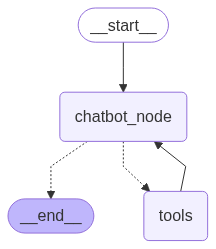

In [16]:
# For persisting state memory
db_path="memory_db/sqlite_memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

sql_memory = SqliteSaver(conn)

graph2 = graph_builder2.compile(checkpointer=sql_memory)
display(Image(graph2.get_graph().draw_mermaid_png()))

In [17]:
# Adding memory based on the thread used
config = {"configurable": {"thread_id": "1"}}

# Create a simple chat interface using gradio
def invoke_graph(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph2.invoke(initial_state, config=config)
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(invoke_graph, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi my name is Ilyan', additional_kwargs={}, response_metadata={}, id='bbc61662-ff48-481e-b255-91a51267c0b0'), AIMessage(content='Hello Ilyan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 122, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-Bq5Z6m237ogAx5Q3UDNttzncPHCVN', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered

In [18]:
list(graph2.get_state(config)) # To look at snapshots

[{'messages': [HumanMessage(content='Hi my name is Ilyan', additional_kwargs={}, response_metadata={}, id='bbc61662-ff48-481e-b255-91a51267c0b0'),
   AIMessage(content='Hello Ilyan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 122, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-Bq5Z6m237ogAx5Q3UDNttzncPHCVN', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filt

In [21]:
# You can also see the state history
list(graph2.get_state_history(config)) # to look at all snapshots in history

[StateSnapshot(values={'messages': [HumanMessage(content='Hi my name is Ilyan', additional_kwargs={}, response_metadata={}, id='bbc61662-ff48-481e-b255-91a51267c0b0'), AIMessage(content='Hello Ilyan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 122, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-Bq5Z6m237ogAx5Q3UDNttzncPHCVN', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 

In [22]:
# Thes snapshots can be used to get the state at a particular time using the ids
# snapshot_config = {"configurable": {"thread_id": "1", "checkpoint_id": "1f05a476-c656-66f4-8022-a4c771eef458"}}
snapshot_config = {"configurable": {"thread_id": "1", "checkpoint_id": "1f059ee8-88d8-6e0c-bfff-96bfdab3e1a3"}}
graph2.invoke(None, config=snapshot_config)

{'messages': [HumanMessage(content='Hi my name is Ilyan', additional_kwargs={}, response_metadata={}, id='eb831e09-3eb8-4d66-ab4c-743ab6acab44'),
  AIMessage(content='Hello Ilyan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 122, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BqFYhjEru8FotDtuCPUtUPnwWgpPp', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filter

## Running browser window with playwright

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

async_browser = create_async_playwright_browser(headless=False)
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
playwright_tools= toolkit.get_tools()

In [3]:
for tool in playwright_tools:
    print(f"Tool Name: {tool.name} == {tool}")

Tool Name: click_element == async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\edan\AppData\Local\ms-playwright\chromium-1179\chrome-win\chrome.exe> version=138.0.7204.23>
Tool Name: navigate_browser == async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\edan\AppData\Local\ms-playwright\chromium-1179\chrome-win\chrome.exe> version=138.0.7204.23>
Tool Name: previous_webpage == async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\edan\AppData\Local\ms-playwright\chromium-1179\chrome-win\chrome.exe> version=138.0.7204.23>
Tool Name: extract_text == async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\edan\AppData\Local\ms-playwright\chromium-1179\chrome-win\chrome.exe> version=138.0.7204.23>
Tool Name: extract_hyperlinks == async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\edan\AppData\Local\ms-playwright\chromium-1179\chrome-win\chrome.exe> version=

In [5]:
# make some tools from the playwright toolkit
tool_dict = {tool.name:tool for tool in playwright_tools}
nav_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

# await nav_tool.arun({"url": "https://www.cnn.com"})
await nav_tool.arun({"url": "https://uae.dubizzle.com/"})
text = await extract_text_tool.arun({})

In [7]:
import textwrap
print(textwrap.fill(text))

dubizzle UAE Classifieds - Best place to rent a property, sell a car
or find a job in UAE Join us in building a safer community. Get
verified to boost your credibility and assist us in creating trust
amongst our users! Verify Now All Cities (UAE) All Cities (UAE) Dubai
Abu Dhabi Ras al Khaimah Sharjah Fujairah Ajman Umm al Quwain Al Ain
Notifications My Searches Favorites Chats My Ads Log in or sign up
Place Your Ad Motors Cars Cars View All Toyota Mercedes-Benz Nissan
BMW Ford Lexus Chevrolet Land Rover Hyundai Audi Volkswagen Honda Kia
Mitsubishi Porsche Jeep Dodge GMC Infiniti Cadillac Rental Cars Rental
Cars View All Toyota Mercedes-Benz BMW Ford Lamborghini Nissan Audi
Ferrari Rental Duration Monthly Rental Weekly Rental Daily Rental Body
Type SUV Sedan Coupe Sports Car New Cars New Cars View All Toyota
Mercedes-Benz Land Rover Nissan Lexus Suzuki Hyundai Jetour Porsche
Rolls-Royce BMW Kia Mitsubishi Jeep MG Ferrari Audi Bentley Volkswagen
Chevrolet Export Cars Export Cars View Al